In [1]:
@file:DependsOn("de.erichseifert.gral:gral-core:0.11")

Ok

In [2]:
import de.erichseifert.gral.graphics.Drawable
import de.erichseifert.gral.io.plots.DrawableWriterFactory
import java.io.ByteArrayOutputStream

fun<T: Drawable> T.toSvg(sizeX: Double, sizeY: Double): Pair<String, Any> {
    val writer = DrawableWriterFactory.getInstance().get("image/svg+xml")

    val buf = ByteArrayOutputStream()

    writer.write(this, buf, sizeX, sizeY)

    return writer.mimeType to buf
}

Ok

In [ ]:
import de.erichseifert.gral.data.DataSeries
import de.erichseifert.gral.data.DataTable
import de.erichseifert.gral.data.filters.Convolution
import de.erichseifert.gral.data.filters.Filter
import de.erichseifert.gral.data.filters.Kernel
import de.erichseifert.gral.data.filters.Median
import de.erichseifert.gral.graphics.Insets2D
import de.erichseifert.gral.graphics.Orientation
import de.erichseifert.gral.plots.XYPlot
import de.erichseifert.gral.plots.lines.DefaultLineRenderer2D
import de.erichseifert.gral.plots.points.PointRenderer
import de.erichseifert.gral.util.GraphicsUtils
import java.awt.Color
import java.util.*

// ported from Gral's ConvolutionExample.java
fun convolutionExample(): XYPlot {

    val SAMPLE_COUNT = 200
    val KERNEL_VARIANCE = 5.0
    val COLOR1 = Color(55, 170, 200)
    val COLOR2 = Color(200, 80, 75)

    // Generate 200 data points
    val data = DataTable(java.lang.Double::class.java, java.lang.Double::class.java).apply {
        val r = Random()
        for (i in 0..SAMPLE_COUNT - 1) {
            val x = i.toDouble() / 2.0 / Math.PI
            val yError = Math.sqrt(3.0 * 0.1) * r.nextGaussian()
            val y = 10.0 * Math.sin(x / 5.0) + yError * yError * yError
            add(x, y)
        }
    }
    val ds = DataSeries("Data", data, 0, 1)

    // Create a smoothed data series from a binomial (near-gaussian) convolution filter
    val kernelLowpass = Kernel.getBinomial(KERNEL_VARIANCE).normalize()
    val dataLowpass = Convolution(data, kernelLowpass, Filter.Mode.REPEAT, 1)
    val dsLowpass = DataSeries("Lowpass", dataLowpass, 0, 1)

    // Create a derived data series from a binomial convolution filter
    val kernelHighpass = Kernel.getBinomial(KERNEL_VARIANCE).normalize().negate().add(Kernel(1.0))
    val dataHighpass = Convolution(data, kernelHighpass, Filter.Mode.REPEAT, 1)
    val dsHighpass = DataSeries("Highpass", dataHighpass, 0, 1)

    // Create a new data series that calculates the moving average using a custom convolution kernel
    val kernelMovingAverageSize = Math.round(4.0 * KERNEL_VARIANCE).toInt()
    val kernelMovingAverage = Kernel.getUniform(kernelMovingAverageSize, kernelMovingAverageSize - 1, 1.0).normalize()
    val dataMovingAverage = Convolution(data, kernelMovingAverage, Filter.Mode.OMIT, 1)
    val dsMovingAverage = DataSeries("Moving Average", dataMovingAverage, 0, 1)

    // Create a new data series that calculates the moving median
    val kernelMovingMedianSize = Math.round(4.0 * KERNEL_VARIANCE).toInt()
    val dataMovingMedian = Median(data, kernelMovingMedianSize, kernelMovingMedianSize - 1, Filter.Mode.OMIT, 1)
    val dsMovingMedian = DataSeries("Moving Median", dataMovingMedian, 0, 1)

    fun XYPlot.formatLine(series: DataSeries, color: Color) {
        setPointRenderers(series, null as List<PointRenderer>?)
        val line = DefaultLineRenderer2D().apply { setColor(color) }
        setLineRenderers(series, line)
    }

    // Create a new xy-plot
    return XYPlot(ds, dsLowpass, dsHighpass, dsMovingAverage, dsMovingMedian).apply {

        // Format plot
        insets = Insets2D.Double(20.0, 40.0, 40.0, 40.0)
        isLegendVisible = true

        // Format legend
        legend.orientation = Orientation.HORIZONTAL
        legend.alignmentY = 1.0

        // Format data series as lines of different colors
        formatLine(ds, Color.BLACK)
        formatLine(dsLowpass, COLOR1)
        formatLine(dsHighpass, GraphicsUtils.deriveDarker(COLOR1))
        formatLine(dsMovingAverage, COLOR2)
        formatLine(dsMovingMedian, GraphicsUtils.deriveDarker(COLOR2))
    }
}

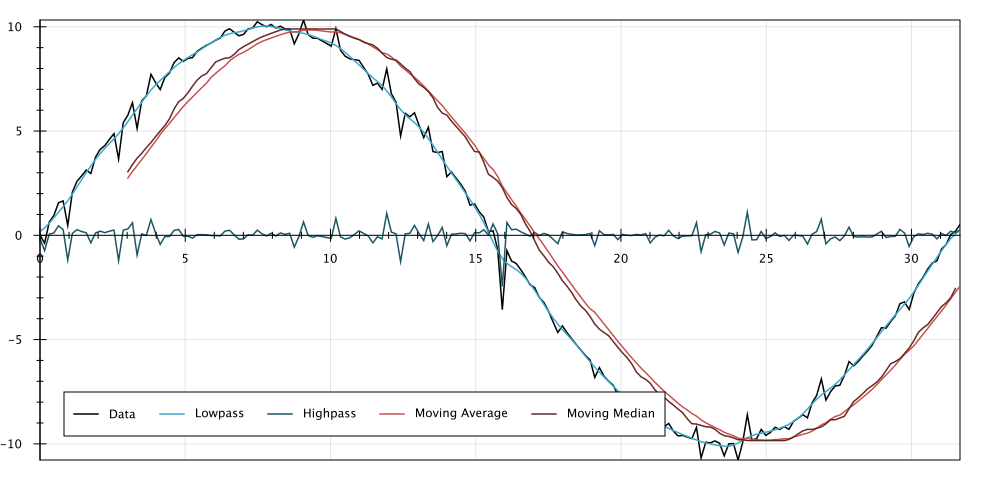

In [4]:
resultOf(convolutionExample().toSvg(1000.0, 500.0))